<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Retail Customer Clustering

### Overview
The dataset given is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts.

### Business Goal
We aim to segment the Customers based on RFM so that the company can target its customers efficiently.

The RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

### Data

You are given a dataset: each row represents a transaction (so, if a given customer buys a t-shirt and socks you will have one row for the t-shirt and one row for the socks).

+ InvoiceNo: id of the invoice
+ StockCode: id of the given clothing
+ Description: description of the clothing item
+ Quantity: quantity purchased
+ InvoiceDate: date of the purchase
+ UnitPrice: unit price of the clothing item
+ CustomerID: id of the customer
+ Country: country of the customer


You are asked to **develop a clustering algorithm** to be able to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

### Business questions

1. **How many groups of customers do we have** 
2. **Which is their profile**


### Steps

You can follow those **steps** :
1. *Explore* and understand the dataset. 
2. Data Cleansing
3. Data preparation (RFM)
4. Assess number of clusters
5. Build clusters
6. Profiling of each cluster: how often they buy, how much, are them a high value group or a low value?

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time, warnings
import datetime as dt
import plotly.io as pio
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
from scipy import stats


%matplotlib inline
warnings.filterwarnings("ignore")
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'
sns.set_style("whitegrid")


## 1 & 2. Explore and Clean the dataset

In [2]:
df = pd.read_csv("retail_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
# clean dataset
df = df[df.isin(["NaN","missing","?","??"]).any(axis=1) == False]
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# drop missing values
df.dropna(axis = 0, inplace=True)

# describe 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,406789.0,12.028359,247.927842,-80995.000,2.00,5.00,12.00,80995.0
UnitPrice,406789.0,3.460811,69.318561,0.001,1.25,1.95,3.75,38970.0
CustomerID,406789.0,15287.795830,1713.573064,12346.000,13954.00,15152.00,16791.00,18287.0


Here, we obtain the summary statistics for the dataset.
- Quantity: The average number of items in one purchase is 12. Notice that standard deviation is high and the minimum and maximum Quantity values are too large, we will remove these outliers in the next section.
- UnitPrice: the average unit price is 3.46 dollars. We also see an outlier problem here by looking at the maximum UnitPrice value.

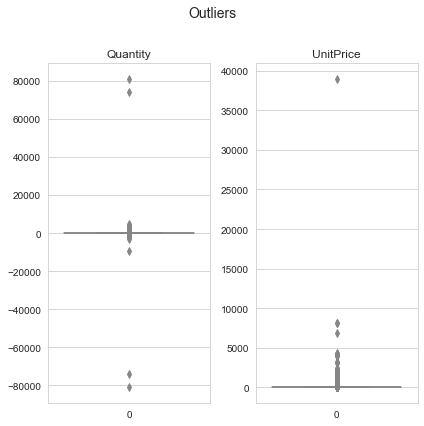

In [4]:
# outlier detection
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,6))
fig.suptitle('Outliers\n', size = 14)

sns.boxplot(ax=axes[0], data=df['Quantity'], palette='Spectral').set_title("Quantity")
sns.boxplot(ax=axes[1], data=df['UnitPrice'], palette='Spectral').set_title("UnitPrice")

plt.tight_layout()


Most of the Quantity and UnitPrice values center around zero, with some outliers in both groups, illustrated here. The outlier problem is much more significant for the UnitPrice variable, which we need to take into careful consideration in the following sections.

In [5]:
# limit outliers
df = df[df['Quantity'].between(0, 100)]
df = df[df['UnitPrice'].between(0, 20)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385513 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    385513 non-null  object        
 1   StockCode    385513 non-null  object        
 2   Description  385513 non-null  object        
 3   Quantity     385513 non-null  int64         
 4   InvoiceDate  385513 non-null  datetime64[ns]
 5   UnitPrice    385513 non-null  float64       
 6   CustomerID   385513 non-null  float64       
 7   Country      385513 non-null  object        
 8   TotalPrice   385513 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 29.4+ MB


I am limiting the outliers with Quantity>100, and UnitPrice>20. I check that by limiting outliers, we do not remove too many values from the dataset. Here, the cleaned dataframe has ~393k values, meaning we dropped around 13k rows by limiting outliers.

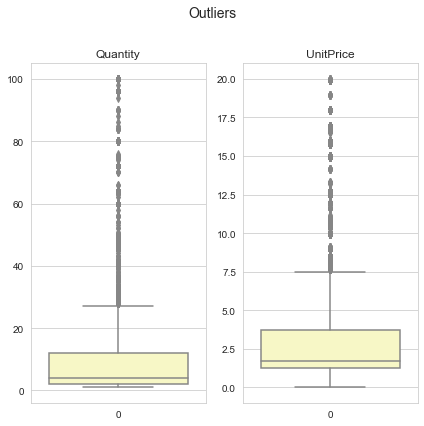

In [6]:
# outlier detection after restricting sample
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,6))
fig.suptitle('Outliers\n', size = 14)

sns.boxplot(ax=axes[0], data=df['Quantity'], palette='Spectral').set_title("Quantity")
sns.boxplot(ax=axes[1], data=df['UnitPrice'], palette='Spectral').set_title("UnitPrice")

plt.tight_layout()


Looks much better now. We see that the variance is much lower after removing outliers and the standard error bar is more defined in our new graph.

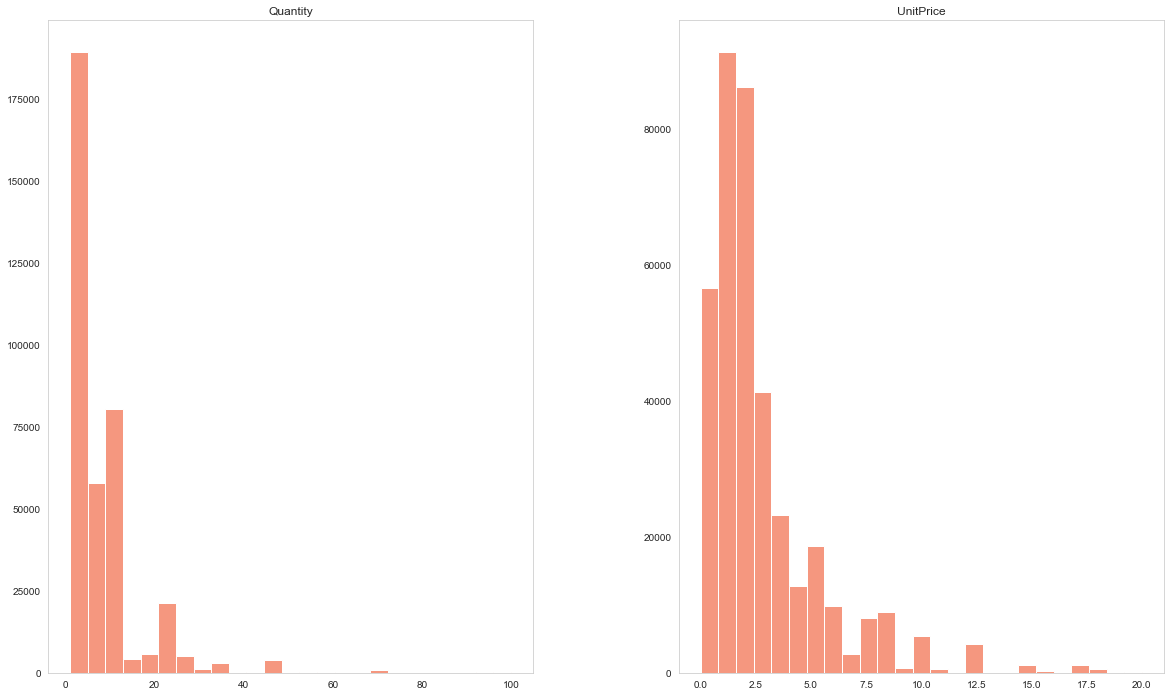

In [7]:
# plot distribution of each attribute
df[['Quantity', 'UnitPrice']].hist(bins=25,
        figsize=(20,12),
        grid=False,
        color='#f5977f');

Some more EDA analysis here. I charted Quantity and UnitPrices in a histogram.
- Quantity: we see that most quantities are under 10, with the majority close to 0. 
- UnitPrice: Most of the units are priced less than 5 dollars, with the majority around the 2 dollar range.


### Mapping number of orders

In [8]:
# plot choropleth
countries = df['Country'].value_counts(normalize=True)
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'# orders'},
            colorscale = 'peach',
            reversescale = False)

layout = dict(title='Total number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)


From the plot, we can see which countries are included in the dataset and which are not. Most included countries are developing Western countries. Here, it is obvious that the United Kingdom has the most number of orders.

### Sales Trend over Time

In [9]:
# sales trend
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

sales_trend = pd.DataFrame(df.groupby("InvoiceDate")["TotalPrice"].sum())

sales_trend_plot = sales_trend.copy()
sales_trend_plot["TotalPrice"] = sales_trend_plot["TotalPrice"].rolling(window=30).mean() 


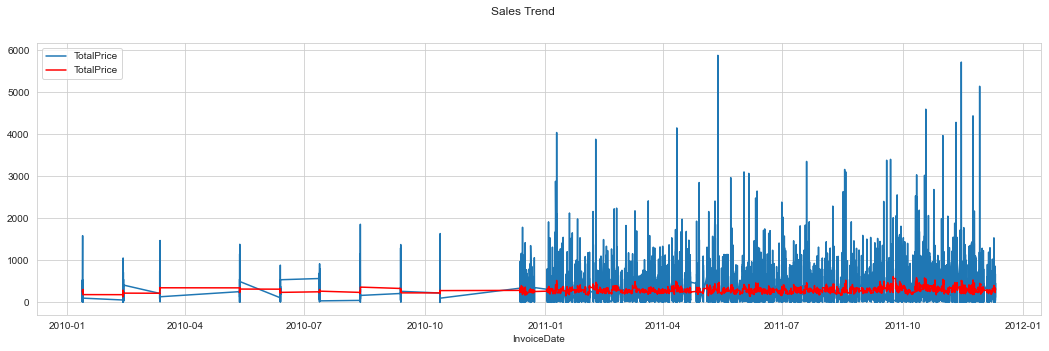

In [10]:
plt.figure(figsize = (18,5)).suptitle('Sales Trend', fontsize=12)
sns.lineplot(data=sales_trend)
sns.lineplot(data=sales_trend_plot, palette=['red'])
plt.show()

Notice that we have some outliers here in terms of dates. Before 2011, there are not enough of sales for us to properly follow its trend. We will drop those values next.

In [11]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]

In [12]:
# remove rows with months before 2010/12
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df = df[(df["InvoiceDate"].dt.year==2011)|(df["InvoiceDate"].dt.month==12)]
sales_trend_cleaned = pd.DataFrame(df.groupby("InvoiceDate")["TotalPrice"].sum())

sales_trend_cleaned_plot = sales_trend_cleaned.copy()
sales_trend_cleaned_plot["TotalPrice"] = sales_trend_cleaned_plot["TotalPrice"].rolling(window=30).mean() 


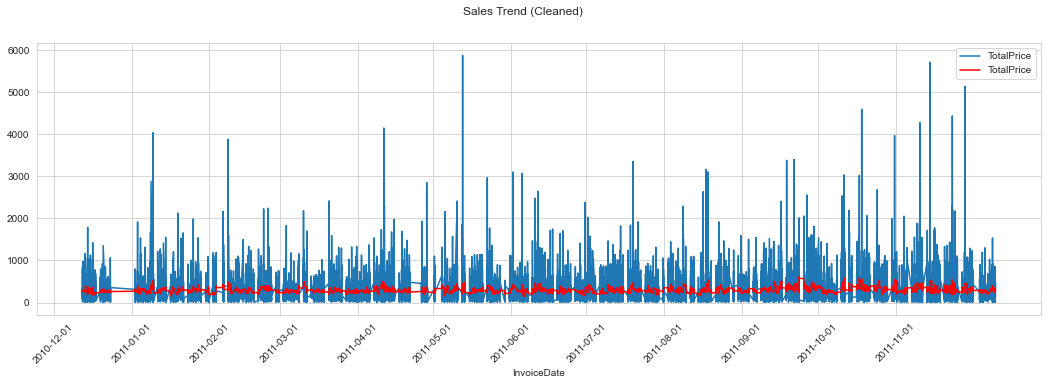

In [13]:
plt.figure(figsize = (18,5)).suptitle('Sales Trend (Cleaned)', fontsize=12)
sns.lineplot(data=sales_trend_cleaned)
sns.lineplot(data=sales_trend_cleaned_plot, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

Much better. Above is the updated sales trend after removing outlier dates. we see that the average sales trend is relatively low.

## 3. Data preparation (RFM)

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

Here, we **develop a clustering algorithm** to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

We will generate these 3 attributes for each customer.


### Model

In [14]:
# scale data for RFM
scaled_df = df.copy()
col_names = ['Quantity', 'UnitPrice']
features = scaled_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_df[col_names] = features

In [15]:
# get most recent date to calculate recency in RFM
most_recent_date = df['InvoiceDate'].max()

rfm = scaled_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (most_recent_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()
rfm


,CustomerID,recency,frequency,monetary
0,12347.0,40,6,2875.99
1,12348.0,220,3,231.08
2,12349.0,19,1,1353.80
3,12350.0,311,1,294.40
4,12352.0,73,7,1385.74
...,...,...,...,...
4129,18280.0,160,1,180.60
4130,18281.0,4,1,80.82
4131,18282.0,216,2,178.05
4132,18283.0,10,16,2094.88


We have generated the RFM table above, grouped by unique customers. From here we can see that there are 4134 customers. For each row, we describe how recent, how many times, and how much the customer has shopped.  

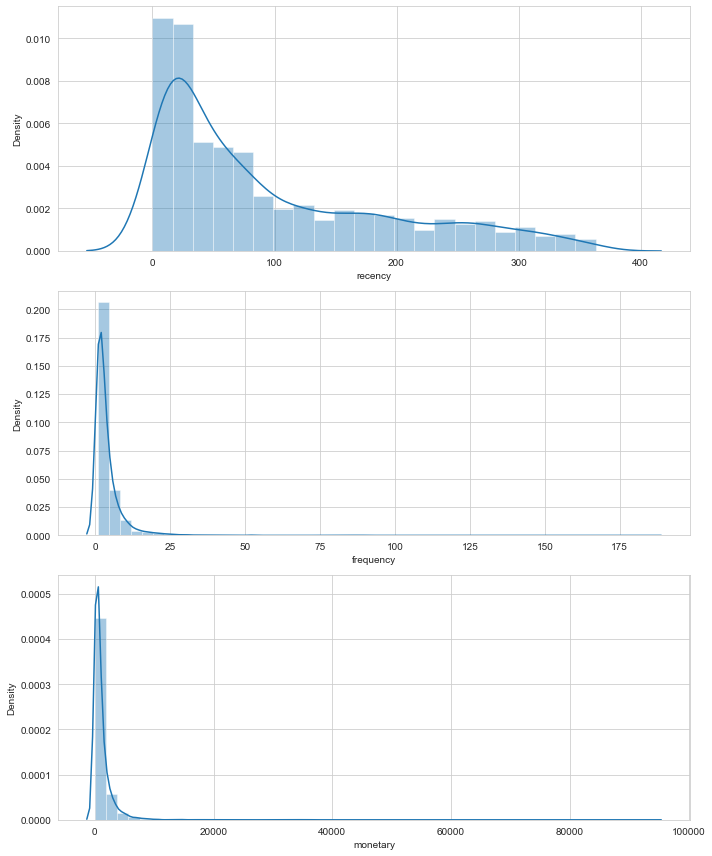

In [16]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.recency)
plt.subplot(3, 1, 2); sns.distplot(rfm.frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm.monetary)
plt.tight_layout()
plt.show()


These are the distribution for each value in our RFM. Notice that frequency and monetary are very skewed, and recency is a little bit skewed. What happens if we took their log?

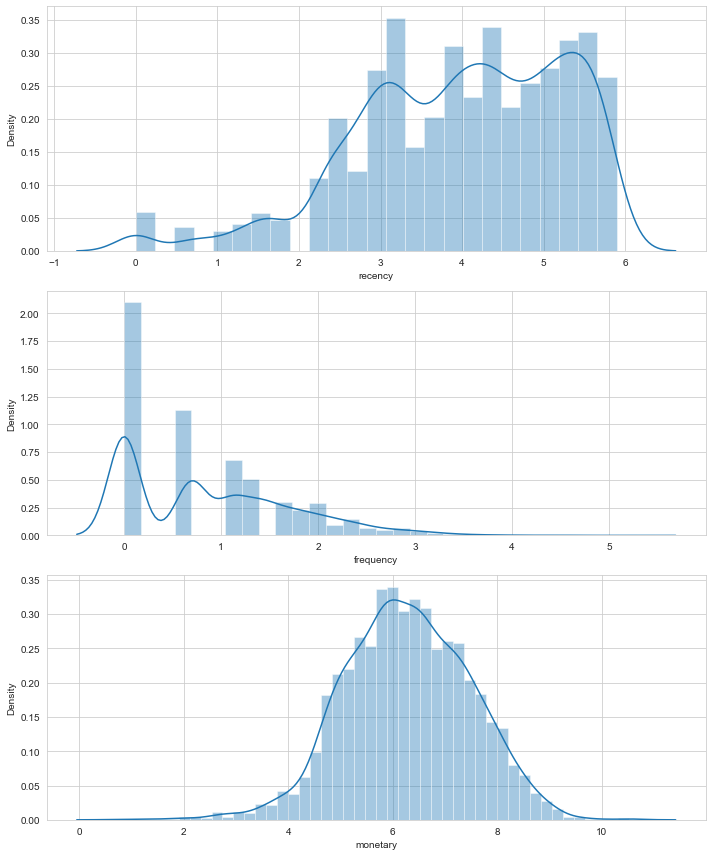

In [17]:
rfm_log = rfm[['recency', 'frequency', 'monetary']].apply(np.log, axis = 1).round(3)
rfm_log = rfm_log[np.isfinite(rfm_log).all(1)]

# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_log.frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_log.monetary)
plt.tight_layout()
plt.show()


After logging our RFM, we see that the values are distributed more clearly. 

## 4-6. Assess, Build, and Profile Clusters (RFM + KMeans)

## i. RFM

First, we will create customer clusters using our RFM numbers. We use quartiles and assign a score from 1 to 5 and bin the values.
- Recency: ranges from 1 (old purchase) to 5 (recent purchase)
- Frequency: ranges from 1 (seldom shopper) to 5 (loyal shopper)
- Monetary: ranges from 1 (small spender) to 5 (big spender)

In [18]:
# get R, F, amd M scores individually and sum them for RFM score
rfm_model = rfm_log.copy()
rfm_model['recency_score'] = pd.qcut(rfm_model['recency'],5,labels = [5, 4, 3, 2, 1])
rfm_model['frequency_score'] = pd.qcut(rfm_model['frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
rfm_model['monetary_score'] = pd.qcut(rfm_model['monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm_model['RFM_SCORE'] = (rfm_model['recency_score'].astype(str) + rfm_model['frequency_score'].astype(str))
rfm_model


,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,3.689,1.792,7.964,4,5,5,45
1,5.394,1.099,5.443,1,3,2,13
2,2.944,0.000,7.211,5,1,4,51
3,5.740,0.000,5.685,1,1,2,11
4,4.290,1.946,7.234,3,5,4,35
...,...,...,...,...,...,...,...
4128,4.304,0.000,5.158,3,2,1,32
4129,5.075,0.000,5.196,2,2,1,22
4130,1.386,0.000,4.392,5,2,1,52
4131,5.375,0.693,5.182,1,3,1,13


We decide to group our customers to 6 groups, based on their RFM score.
- **"Inactive"**:  These customers have the lowest recency and frequency scores, meaning they the last time they purchased something was a long time ago and they do not purchase often.
- **"At Risk"**: These customers have the lowest recency, and have medium frequency scores, meaning the last purchased was a long time ago, and are at risk of falling into the lowest frequency group.
- **"Loyal"**: These customers have the highest frequency score, meaning they come back often.
- **"New"**: These are customers that have recently purchased something.
- **"Potential"**: These are customers that have recently purchased something but do not come back often, they have the potential to become higher frequency customers.
- **"Champions"**: These customers have just purchased recently and come back often.


In [19]:
seg_map = {
    r'[1-2][1-2]': 'Inactive',
    r'[1-3][3-4]': 'At Risk',
    r'[1-4][4-5]': 'Loyal',
    r'51': 'New',
    r'[3-5][1-3]': 'Potential',
    r'5[4-5]': 'Champions'
}
rfm_model['segment'] = rfm_model['RFM_SCORE'].replace(seg_map, regex=True)
rfm_model.reset_index(inplace=True)
rfm_model.head()

,index,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,0,3.689,1.792,7.964,4,5,5,45,Loyal
1,1,5.394,1.099,5.443,1,3,2,13,At Risk
2,2,2.944,0.000,7.211,5,1,4,51,New
3,3,5.740,0.000,5.685,1,1,2,11,Inactive
4,4,4.290,1.946,7.234,3,5,4,35,Loyal


In [20]:
# count the number of occurance for each cluster
segments_count = rfm_model.groupby("segment").agg({"index": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.sort_values(by='count', ascending=False).head(15)

,segment,count
2,Inactive,995
0,At Risk,901
5,Potential,864
3,Loyal,630
1,Champions,614
4,New,58


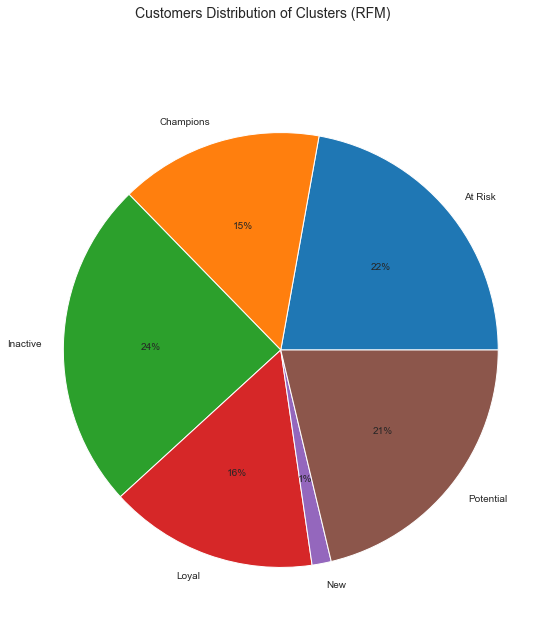

In [21]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters (RFM)', fontsize=14)
plt.pie(segments_count["count"], labels = segments_count["segment"], autopct='%.0f%%')
plt.show()

We grouped our customers into 6 groups for RFM. The largest group of customers are inactive, meaning they have the lowest recency and frequency scores. The second largest groups are At Risk and Potential groups. The company should focus on turning these potential and at risk groups to loyal or even champions customers. At last, they should spend the least time for New clients for now, given that they have the smallest share.

## ii. KMeans
Again, we want determine the optimal number of clusters into which the data may be clustered. Now, we apply a second method, the k-means elbow method.  The idea is to run k-means clustering for a range of clusters k and for each value, we are calculating the sum of squared distances from each point to its assigned center.

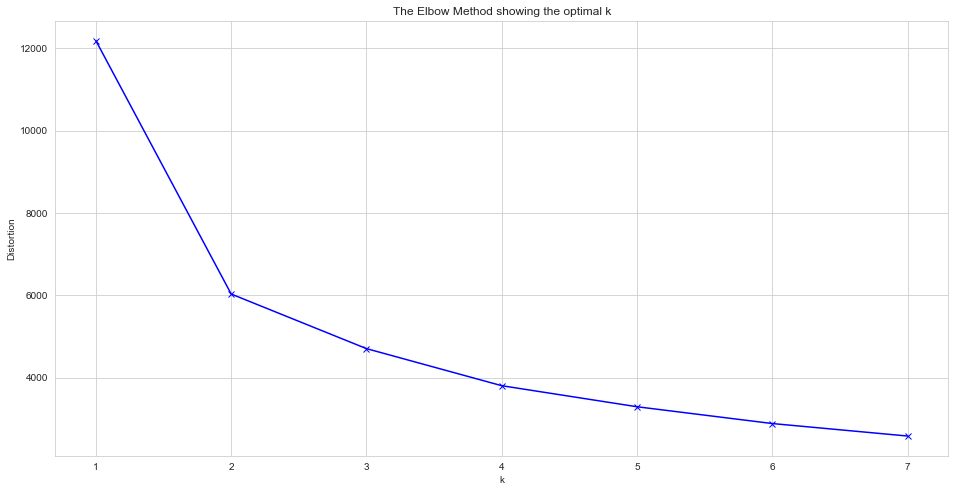

In [22]:
# elbow method
scaler = StandardScaler()
scaler.fit(rfm_log);

ks = range(1,8)
distortions = []
for k in ks :
    # Create a KMeans clusters
    kmeanModel = KMeans(n_clusters=k,random_state=1)
    kmeanModel.fit(scaler.transform(rfm_log))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(ks, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


Using the sklearn kmeans model, we graph the optimal k's above. Notice the point of inflection on the curve ("elbow") of the curve is at k=3. Thus, this is our best value of k and we will cluster our data into 3 groups.

In [23]:
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=1)
kmeans.fit(rfm_log)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(rfm_log))
centroid_df


,recency,frequency,monetary
0,2.456422,2.004608,7.680550
1,5.017719,0.177944,5.222094
2,3.851096,0.943590,6.511557


Now, we have 3 segments, which we got from the elbow method.
- **Cluster 0:** "Loyal and High Spenders" - These customers have the highest spending and come back the most often. Our favorite customers, we want to keep them.
- **Cluster 1:** "Recent Customers" - These are customers that have recently purchased an item. We want to hold onto these customers and turn them into loyal customers.
- **Cluster 2:** "Average Customers" - These are the customers between "Recent Customers" and "Loyal and High Spenders", we want to keep them as well as turn them into loyal customers.


We calculate the centroid, defined by the means of all points that are in the same cluster. The algorithm first chooses random points as centroids and then iterates adjusting them until full convergence.

In [24]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

df_kmeans = rfm_log.copy()
df_kmeans['labels'] = df_labels['labels'].values

agg_list=["mean", "count", "max",]
df_kmeans[["labels", "recency", "frequency", "monetary"]].groupby("labels").agg(agg_list)

recency              frequency              monetary              
            mean count    max      mean count    max     mean count     max
labels                                                                     
0       2.456422   891  5.024  2.004608   891  5.198  7.68055   891  10.724
1       5.018113  1545  5.894  0.177944  1545  1.792  5.22245  1545   7.117
2       3.850722  1626  5.756  0.943590  1626  2.485  6.51122  1626   8.489

In [25]:
label_map = {
    0: 'Loyal and High Spenders',
    1: 'Recent Customers',
    2: 'Average Customers'
}

df_kmeans['labels'] = df_kmeans['labels'].map(label_map)


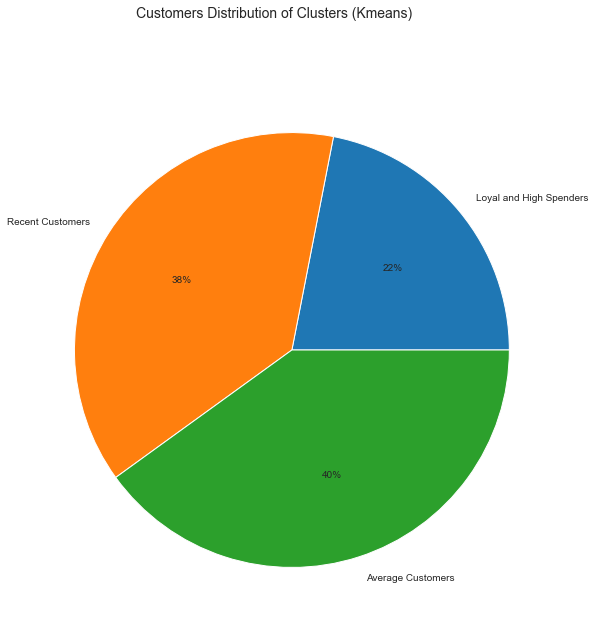

In [26]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"index": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters (Kmeans)', fontsize=14)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')

plt.show()

We see that there are 38% recent customers that have a potential to be turned into loyal and high spenders, we should actively work on that. on the 40% of average customers, the company should try to retain them as much as possible. There are not as many loyal and high spenders, at 22%, the company should prioritize these customers and prevent them from becoming average customers. We have less clusters using the KMeans method, which can be useful in particular cases. However, it is not as detailed and robust as the RFM clusters given its lower number of groups.

<!-- The RFM score is generated by concactinating the strings from each score. For example, in our entry here, the customer is a recent customer, so they got a high `recency_score` of 4; they are a frequent buyer, so they got the highest `frequency_score` of 5; but they did not spend as much, thus a lower `monetary_score` of 2. The ideal customer is one that recently purchased an item, shops a lot, and spends a lot (`RFM_SCORE == 555`). -->

## Business questions

1. **How many groups of customers do we have** 
- Under the RFM method, we have 6: "Inactive", "At Risk", "Potential", "Loyal", "Champions", "New"
- Under the KMeans method, we have 3: "Loyal and High Spenders", "Recent Customers", and "Average Customers".
 
2. **Which is their profile**
- To summarize, under RFM elbow clustering:
    - **"Inactive"**:  These customers have the lowest recency and frequency scores, meaning they the last time they purchased something was a long time ago and they do not purchase often.
    - **"At Risk"**: These customers have the lowest recency, and have medium frequency scores, meaning the last purchased was a long time ago, and are at risk of falling into the lowest frequency group.
    - **"Loyal"**: These customers have the highest frequency score, meaning they come back often.
    - **"New"**: These are customers that have recently purchased something.
    - **"Potential"**: These are customers that have recently purchased something but do not come back often, they have the potential to become higher frequency customers.
    - **"Champions"**: These customers have just purchased recently and come back often.
- And under KMeans:
    - **Cluster 0:** "Loyal and High Spenders" - These customers have the highest spending and come back the most often. Our favorite customers, we want to keep them.
    - **Cluster 1:** "Recent Customers" - These are customers that have recently purchased an item. We want to hold onto these customers and turn them into loyal customers.
    - **Cluster 2:** "Average Customers" - These are the customers between "Recent Customers" and "Loyal and High Spenders", we want to keep them as well as turn them into loyal customers.